In [14]:

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
pd.set_option("display.max_columns", 0)
data = pd.read_csv("movie_dataset.csv")
data.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


In [16]:
selected_features = ['index', 'title', 'genres', 'keywords', 'cast', 'director']

df = data[selected_features]
df.head()

,index,title,genres,keywords,cast,director
0,0,Avatar,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,Sam Worthington Zoe Saldana Sigourney Weaver S...,James Cameron
1,1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,Johnny Depp Orlando Bloom Keira Knightley Stel...,Gore Verbinski
2,2,Spectre,Action Adventure Crime,spy based on novel secret agent sequel mi6,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,Sam Mendes
3,3,The Dark Knight Rises,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,Christian Bale Michael Caine Gary Oldman Anne ...,Christopher Nolan
4,4,John Carter,Action Adventure Science Fiction,based on novel mars medallion space travel pri...,Taylor Kitsch Lynn Collins Samantha Morton Wil...,Andrew Stanton


In [17]:
df.dtypes

index        int64
title       object
genres      object
keywords    object
cast        object
director    object
dtype: object

In [18]:
df.isnull().sum()

index         0
title         0
genres       28
keywords    412
cast         43
director     30
dtype: int64

<AxesSubplot:>

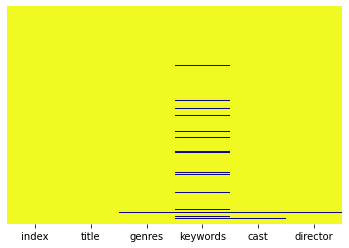

In [19]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='plasma_r')

<AxesSubplot:>

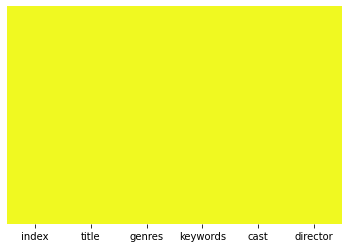

In [20]:

df = df.fillna("")
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='plasma_r')

In [21]:
def combine_rows(row):
    combined_feature = row['genres']+" "+row['keywords']+" "+row['cast']+" "+row['director']
    return combined_feature

df["combined_features"] = df.apply(combine_rows, axis=1)
df.head()

,index,title,genres,keywords,cast,director,combined_features
0,0,Avatar,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,Sam Worthington Zoe Saldana Sigourney Weaver S...,James Cameron,Action Adventure Fantasy Science Fiction cultu...
1,1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,Johnny Depp Orlando Bloom Keira Knightley Stel...,Gore Verbinski,Adventure Fantasy Action ocean drug abuse exot...
2,2,Spectre,Action Adventure Crime,spy based on novel secret agent sequel mi6,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,Sam Mendes,Action Adventure Crime spy based on novel secr...
3,3,The Dark Knight Rises,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,Christian Bale Michael Caine Gary Oldman Anne ...,Christopher Nolan,Action Crime Drama Thriller dc comics crime fi...
4,4,John Carter,Action Adventure Science Fiction,based on novel mars medallion space travel pri...,Taylor Kitsch Lynn Collins Samantha Morton Wil...,Andrew Stanton,Action Adventure Science Fiction based on nove...


In [22]:
def find_cosine_similarity(features):
    cv = CountVectorizer() #vector representation
    count_mat = cv.fit_transform(features) #matrix of number count of each word
    cosine_sim = cosine_similarity(count_mat) #2D NxN coeff. matrix of cosine angles
    return cosine_sim

In [23]:
def get_title_from_index(index):
    try:
        title = df[df.index == index]["title"].values[0]
        return title
    except Exception as e:
        return "Sorry, Movie not found! Try another."

def get_index_from_title(title):
    try:
        return df[df.title == title]["index"].values[0]
    except Exception as e:
        return -1

In [24]:
df.head()

,index,title,genres,keywords,cast,director,combined_features
0,0,Avatar,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,Sam Worthington Zoe Saldana Sigourney Weaver S...,James Cameron,Action Adventure Fantasy Science Fiction cultu...
1,1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,Johnny Depp Orlando Bloom Keira Knightley Stel...,Gore Verbinski,Adventure Fantasy Action ocean drug abuse exot...
2,2,Spectre,Action Adventure Crime,spy based on novel secret agent sequel mi6,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,Sam Mendes,Action Adventure Crime spy based on novel secr...
3,3,The Dark Knight Rises,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,Christian Bale Michael Caine Gary Oldman Anne ...,Christopher Nolan,Action Crime Drama Thriller dc comics crime fi...
4,4,John Carter,Action Adventure Science Fiction,based on novel mars medallion space travel pri...,Taylor Kitsch Lynn Collins Samantha Morton Wil...,Andrew Stanton,Action Adventure Science Fiction based on nove...


In [27]:
# Acessing TMDB API 

from tmdbv3api import TMDb
from tmdbv3api import Movie
import json
import requests

In [28]:
tmdb = TMDb()
tmdb_movie = Movie()

tmdb.api_key = "API_KEY"

In [29]:
def get_new_movie_data(correct_movie_name):
    
    # Getting Title -> correct_movie_name
    movie_id = correct_movie_name.id
    
    # Getting Genre
    response1 = requests.get('https://api.themoviedb.org/3/movie/{}?api_key={}'.format(movie_id,tmdb.api_key))
    json_data1 = response1.json()
    genres = [json_data1['genres'][i]['name'] for i in range(len(json_data1['genres']))]

    # Getting Director
    response2 = requests.get('https://api.themoviedb.org/3/movie/{} \
                             /credits?api_key={}'.format(movie_id, tmdb.api_key))
    
    json_data2 = response2.json()

    directors = []
    for nested_dict in json_data2['crew']:
        if nested_dict['department'] == 'Directing':
            directors.append(nested_dict['name'])

    # Getting Cast
    cast = []
    for nested_dict in json_data2['cast']:
        cast.append(nested_dict['name'])

    # Getting Keywords
    response3 = requests.get('https://api.themoviedb.org/3/movie/{} \
                             /keywords?api_key={}'.format(movie_id, tmdb.api_key))

    json_data3 = response3.json()

    keywords = []
    for nested_dict in json_data3['keywords']:
        keywords.append(nested_dict['name'])

    data = {'index': int(df.index[-1]),
            'title': str(correct_movie_name),
            'genres': genres,
            'keywords': keywords,
            'cast': cast,
            'director': directors}
    
    new_record = pd.DataFrame.from_dict(data, orient='index')
    new_record = new_record.transpose()
    
    # converting list of strings to string
    for col in ['genres','keywords','cast','director']:
        new_record[col] = new_record[col].apply(' '.join)
    
    new_record['combined_features'] = new_record.apply(combine_rows, axis=1)

    return new_record

In [30]:
def get_recommendation(user_movie_input, df):
    
    cosine_sim = find_cosine_similarity(df['combined_features'])

    correct_movie_name = tmdb_movie.search(user_movie_input)

    movie_index = get_index_from_title(str(correct_movie_name[0]))
    print("Corrected movie name: ", correct_movie_name[0])
    
    if movie_index == -1:
        # If movie index is not found in our data
        # Generate that movie data and append to df, find cosine similarity again and repeat the process
        new_record = get_new_movie_data(correct_movie_name[0])
        df = df.append(new_record, ignore_index=True)
        cosine_sim = find_cosine_similarity(df['combined_features'])
        movie_index = get_index_from_title(str(correct_movie_name[0]))

    similar_movies = list(enumerate(cosine_sim[movie_index]))

    sorted_similar_movies = sorted(similar_movies, key=lambda x:x[1], reverse=True)[1:]
    
    i=0
    print("Top 6 similar movies to '{}' are:".format(user_movie_input))
    print()
    
    for element in sorted_similar_movies:
        print(get_title_from_index(element[0]))
        i=i+1
        if i>5:
            break

In [ ]:
get_recommendation("avengers", df)